### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Timestamp
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from datetime import datetime


%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")


In [2]:
data = pd.read_csv('./data/train.csv')


In [3]:
data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0


## Exploratory Analysis

#### 0. Preprocessing Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
#to find out unique value
print(data['family'].unique())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


#### 1. Extracting Data to Model

Our data set has a number of stores, each with daily sales volumes for many families. 

To facilitate our first time series model, we need to use a single store and single item 

**Aggregate all of the sales for STORE 1 and `POULTRY` into a new dataframe called `sales`.**


In [6]:
sales = data.loc[(data['store_nbr'] == 1) & (data['family'] == 'POULTRY')]

In [7]:
sales.head()

,id,date,store_nbr,family,sales,onpromotion
28,28,2013-01-01,1,POULTRY,0.000,0
1810,1810,2013-01-02,1,POULTRY,247.297,0
3592,3592,2013-01-03,1,POULTRY,187.278,0
5374,5374,2013-01-04,1,POULTRY,258.023,0
7156,7156,2013-01-05,1,POULTRY,212.333,0


In [8]:
# Set index to be the date column as a DatetimeIndex.
sales.set_index(pd.to_datetime(sales['date']), inplace=True)

# Confirm.
sales.head()

,id,date,store_nbr,family,sales,onpromotion
date,,,,,,
2013-01-01,28,2013-01-01,1,POULTRY,0.000,0
2013-01-02,1810,2013-01-02,1,POULTRY,247.297,0
2013-01-03,3592,2013-01-03,1,POULTRY,187.278,0
2013-01-04,5374,2013-01-04,1,POULTRY,258.023,0
2013-01-05,7156,2013-01-05,1,POULTRY,212.333,0


In [9]:
#remove unnecessary columns as we are only interested in date and sales
sales = sales.drop(columns=['id','date','store_nbr','family','onpromotion'])

In [10]:
sales.head()

,sales
date,
2013-01-01,0.000
2013-01-02,247.297
2013-01-03,187.278
2013-01-04,258.023
2013-01-05,212.333


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `sales` with time on the $x$-axis.**

In [11]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

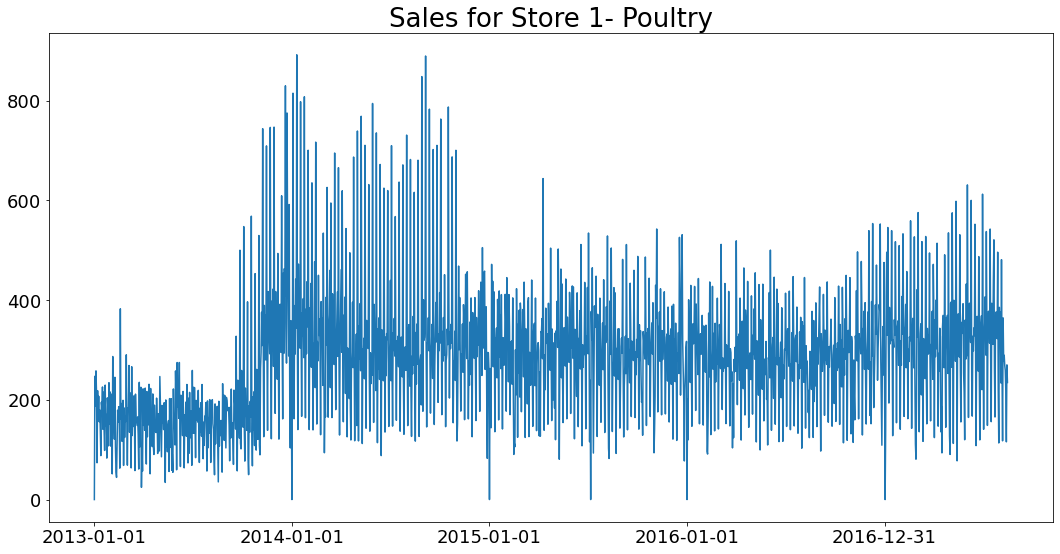

In [12]:
# Generate a time plot of our data.
plot_series(sales, ['sales'], title = "Sales for Store 1- Poultry", steps=364)

**2b. plot the monthly mean for sales

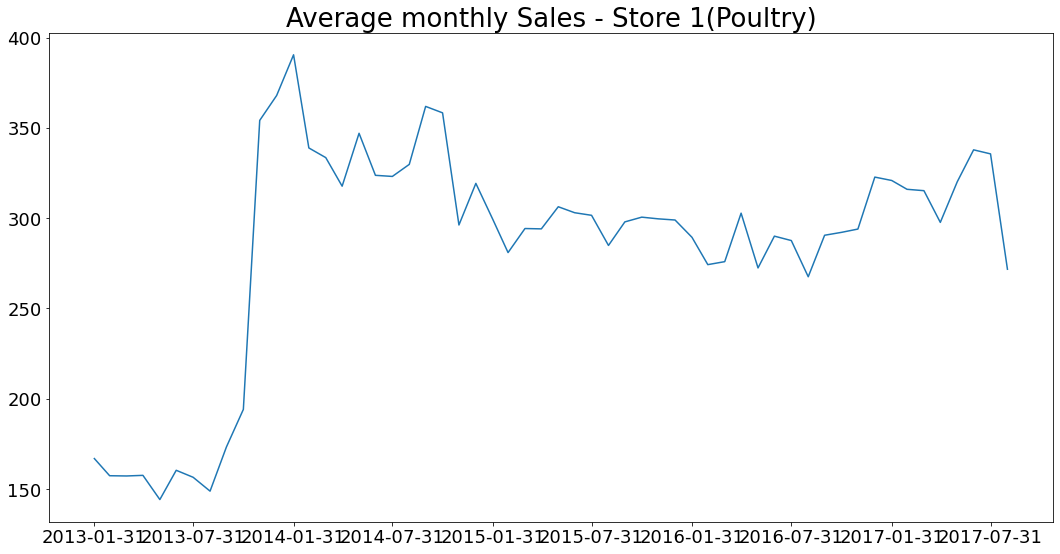

In [13]:
# Generate a time plot of our data.
plot_series(sales.resample('M').mean(), cols=['sales'], title='Average monthly Sales - Store 1(Poultry)', steps=6)

#### 3. Hyperparameter Tuning

**Parameter differencing**

In [14]:
sales.head()

,sales
date,
2013-01-01,0.000
2013-01-02,247.297
2013-01-03,187.278
2013-01-04,258.023
2013-01-05,212.333


In [15]:
# Look at the first 5 values of our series, differenced once.
sales.diff().head()

,sales
date,
2013-01-01,NaN
2013-01-02,247.297
2013-01-03,-60.019
2013-01-04,70.745
2013-01-05,-45.690


In [16]:
# Look at the first 5 values of our series, differenced twice.
sales.diff().diff().head()

,sales
date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,-307.316
2013-01-04,130.764
2013-01-05,-116.435


In [17]:
# Create first_diff_sales and second_diff_sales
# columns in df.
sales['first_diff_sales'] = sales['sales'].diff()
sales['second_diff_sales'] = sales['sales'].diff().diff()

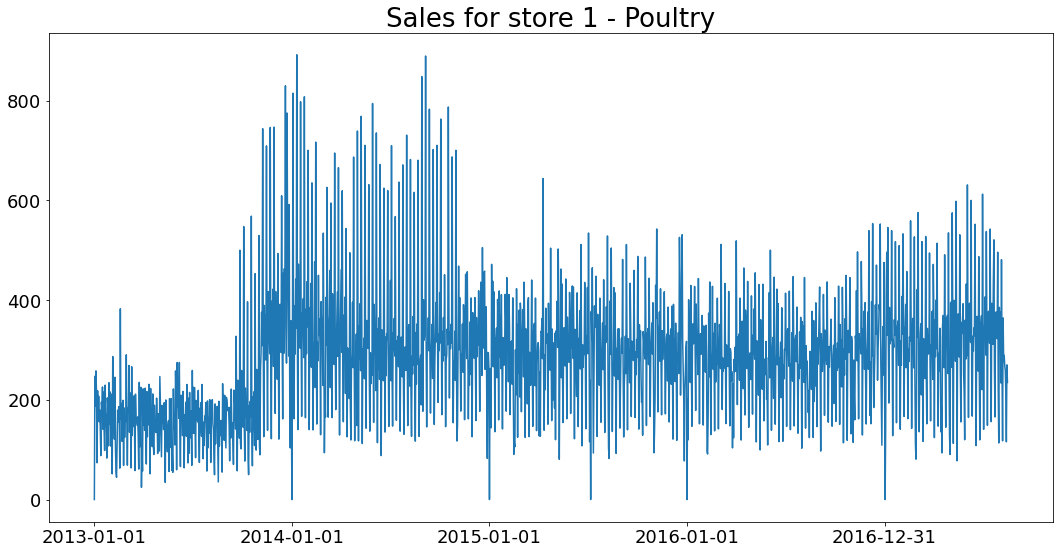

In [18]:
# sales data.
plot_series(sales,
            ['sales'],
            title = "Sales for store 1 - Poultry",
            steps = 364)

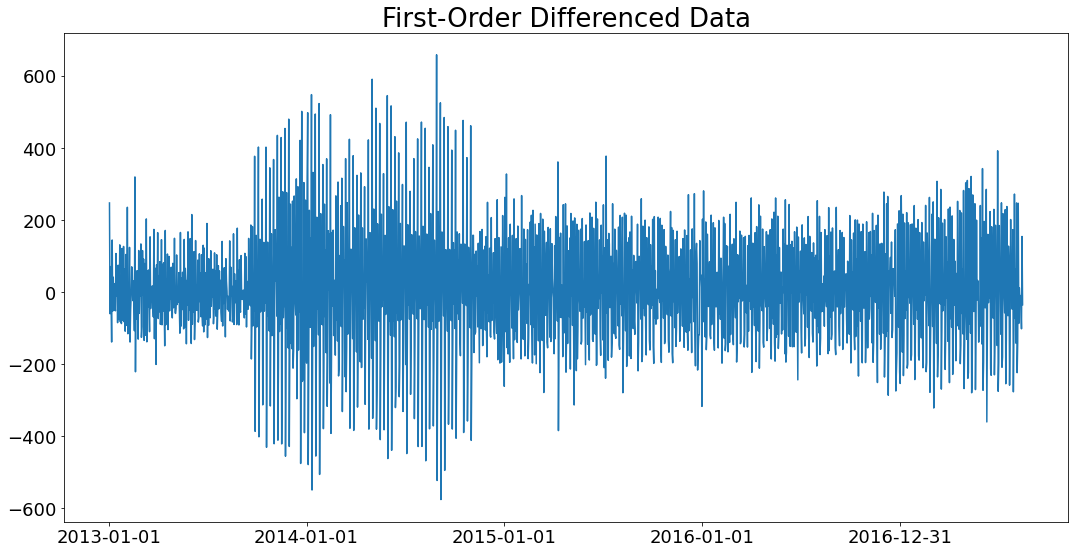

In [19]:
# Examine sales, differenced once.

plot_series(sales, ['first_diff_sales'], title = "First-Order Differenced Data", steps = 364)

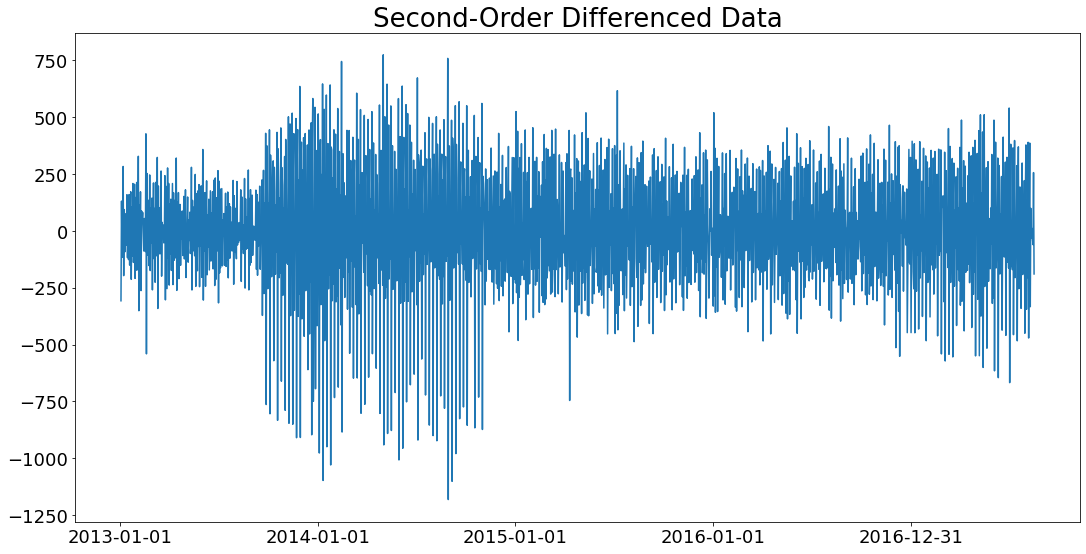

In [20]:
# Examine sales, differenced twice.

plot_series(sales, ['second_diff_sales'], title = "Second-Order Differenced Data", steps = 364)

**Augmented Dickey-Fuller Test**

In [21]:
# Run ADF test on original (non-differenced!) data.
adfuller(sales['sales'])

(-2.54355725449664,
 0.10523276189243835,
 21,
 1662,
 {'1%': -3.4342906911169404,
  '5%': -2.8632805908715726,
  '10%': -2.5676966486957706},
 18777.686827679372)

In [22]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [23]:
# Run ADF test on original (non-differenced!) data.

interpret_dftest(adfuller(sales['sales']))

Test Statistic   -2.544
p-value           0.105
dtype: float64

In [24]:
# Run the ADF test on our once-differenced data.

interpret_dftest(adfuller(sales['sales'].diff().dropna()))

Test Statistic   -16.037
p-value            0.000
dtype: float64

In [25]:
# Run the ADF test on our twice-differenced data.

interpret_dftest(adfuller(sales['sales'].diff().diff().dropna()))

Test Statistic   -19.771
p-value            0.000
dtype: float64

#### 4. ARIMA model
**Train-test split**

In [26]:
# Create train-test split.
y_train, y_test = train_test_split(sales['sales'], test_size=.2, shuffle=False)

In [33]:
y_train


date
2013-01-01     0.000
2013-01-02   247.297
2013-01-03   187.278
2013-01-04   258.023
2013-01-05   212.333
               ...  
2016-09-07   257.099
2016-09-08   293.563
2016-09-09   411.402
2016-09-10   317.593
2016-09-11   168.855
Name: sales, Length: 1347, dtype: float64

In [28]:
print(f'Number of observations: {len(sales)}')
print(f'Number of training observations: {round(len(sales) * 0.8)}')
print(f'Number of testing observations: {len(sales) - round(len(sales) * 0.8)}')



Number of observations: 1684
Number of training observations: 1347
Number of testing observations: 337


In [29]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog=y_train, order=(p, 1, q))
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting ARIMA(0, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56195D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   6.562D+00
  F =   6.5619517454624079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(0,1,0) is: 17668.7740987848
Attempting ARIMA(0, 1, 1)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


The AIC for ARIMA(0,1,3) is: 16615.519464124394
Attempting ARIMA(0, 1, 4)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16949D+00    |proj g|=  9.07283D-03

At iterate    5    f=  6.16801D+00    |proj g|=  2.11564D-04

At iterate   10    f=  6.16801D+00    |proj g|=  2.66454D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   2.665D-07   6.168D+00
  F =   6.1680071490326691     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH          

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.44107D+00    |proj g|=  6.07514D-05

At iterate   10    f=  6.44107D+00    |proj g|=  1.59872D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     19      1     0     0   8.882D-08   6.441D+00
  F =   6.4410747085416231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(1,1,0) is: 17345.37311539405
Attempting ARIMA(1, 1, 1)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19077D+00    |proj g|=  3.42721D-

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   8.882D-08   6.175D+00
  F =   6.1751663421375005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(1,1,2) is: 16633.54779303415
Attempting ARIMA(1, 1, 3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15010D+00    |proj g|=  1.05338D-03

At iterate    5    f=  6.15006D+00    |proj g|=  2.59348D-04

At iterate   10    f=  6.15006D+00    |proj g|=  1.77636D-

 This problem is unconstrained.
 This problem is unconstrained.


The AIC for ARIMA(1,1,3) is: 16567.96466555188
Attempting ARIMA(1, 1, 4)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14722D+00    |proj g|=  1.24452D-03

At iterate    5    f=  6.14711D+00    |proj g|=  1.74776D-03

At iterate   10    f=  6.14710D+00    |proj g|=  8.79297D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     17      1     0     0   2.665D-07   6.147D+00
  F =   6.1470985882747877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH           

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15502D+00    |proj g|=  1.04396D-03

At iterate    5    f=  6.15501D+00    |proj g|=  2.04281D-06

At iterate   10    f=  6.15501D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   1.776D-07   6.155D+00
  F =   6.1550096873424369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,2) is: 16581.28607832584
Attempting ARIMA(2, 1, 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04913D+00    |proj g|=  9.80993D-03

At iterate    5    f=  6.04813D+00    |proj g|=  4.94031D-03

At iterate   10    f=  6.04789D+00    |proj g|=  9.23066D-03

At iterate   15    f=  6.04785D+00    |proj g|=  4.39124D-03

At iterate   20    f=  6.04779D+00    |proj g|=  7.25455D-03


 This problem is unconstrained.



At iterate   25    f=  6.04776D+00    |proj g|=  1.58362D-03

At iterate   30    f=  6.04776D+00    |proj g|=  1.79634D-03

At iterate   35    f=  6.04776D+00    |proj g|=  3.90799D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     60      1     0     0   2.309D-06   6.048D+00
  F =   6.0477570252747901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,3) is: 16294.561912039735
Attempting ARIMA(2, 1, 4)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bou

 This problem is unconstrained.



At iterate   10    f=  6.04717D+00    |proj g|=  4.03304D-03

At iterate   15    f=  6.04711D+00    |proj g|=  1.45234D-02

At iterate   20    f=  6.04703D+00    |proj g|=  2.19389D-03

At iterate   25    f=  6.04701D+00    |proj g|=  7.15339D-03

At iterate   30    f=  6.04701D+00    |proj g|=  3.31291D-05

At iterate   35    f=  6.04701D+00    |proj g|=  4.44089D-06

At iterate   40    f=  6.04701D+00    |proj g|=  3.73035D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     69      1     0     0   2.665D-06   6.047D+00
  F =   6.0470055954132924     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.776D-07   6.174D+00
  F =   6.1735249450285554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,1) is: 16631.12915201687
Attempting ARIMA(3, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15337D+00    |proj g|=  1.63958D-03

At iterate    5    f=  6.15334D+00    |proj g|=  6.51923D-05

At iterate   10    f=  6.15334D+00    |proj g|=  2.66454D-

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     16      1     0     0   8.882D-08   6.153D+00
  F =   6.1533377248095746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,2) is: 16578.785155187375
Attempting ARIMA(3, 1, 3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04697D+00    |proj g|=  1.01799D-02


 This problem is unconstrained.



At iterate    5    f=  6.04691D+00    |proj g|=  8.38938D-03

At iterate   10    f=  6.04683D+00    |proj g|=  1.90532D-03

At iterate   15    f=  6.04682D+00    |proj g|=  9.48130D-03

At iterate   20    f=  6.04681D+00    |proj g|=  5.60174D-04

At iterate   25    f=  6.04681D+00    |proj g|=  1.36994D-02

At iterate   30    f=  6.04680D+00    |proj g|=  5.43920D-03

At iterate   35    f=  6.04679D+00    |proj g|=  4.25491D-03

At iterate   40    f=  6.04678D+00    |proj g|=  1.42615D-03

At iterate   45    f=  6.04677D+00    |proj g|=  3.22702D-03

At iterate   50    f=  6.04677D+00    |proj g|=  1.63425D-05

At iterate   55    f=  6.04677D+00    |proj g|=  2.39808D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03940D+00    |proj g|=  2.33878D-02

At iterate    5    f=  6.03914D+00    |proj g|=  1.12157D-02

At iterate   10    f=  6.03885D+00    |proj g|=  8.53060D-03

At iterate   15    f=  6.03872D+00    |proj g|=  8.91349D-03

At iterate   20    f=  6.03868D+00    |proj g|=  1.36682D-03

At iterate   25    f=  6.03865D+00    |proj g|=  1.22284D-03

At iterate   30    f=  6.03865D+00    |proj g|=  9.46132D-03

At iterate   35    f=  6.03864D+00    |proj g|=  1.15437D-03

At iterate   40    f=  6.03864D+00    |proj g|=  1.46395D-02

At iterate   45    f=  6.03863D+00    |proj g|=  5.49782D-04

At iterate   50    f=  6.03863D+00    |proj g|=  4.89742D-04

At iterate   55    f=  6.03863D+00    |proj g|=  2.26397D-04

At iterate   60    f=  6.03863D+00    |proj g|=  6.87805D-04

At iterate   65    f=  6.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   70    f=  6.03863D+00    |proj g|=  2.11120D-04

At iterate   75    f=  6.03863D+00    |proj g|=  4.67182D-05

At iterate   80    f=  6.03863D+00    |proj g|=  6.66134D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     82    127      2     0     0   8.242D-05   6.039D+00
  F =   6.0386289095845100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,4) is: 16273.989024601502
Attempting ARIMA(4, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bou

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17192D+00    |proj g|=  2.27853D-03

At iterate    5    f=  6.17189D+00    |proj g|=  1.18305D-04

At iterate   10    f=  6.17189D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     17      1     0     0   8.882D-08   6.172D+00
  F =   6.1718934381596018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


The AIC for ARIMA(4,1,1) is: 16628.737135525647
Attempting ARIMA(4, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14030D+00    |proj g|=  1.48850D-03

At iterate    5    f=  6.14027D+00    |proj g|=  1.25056D-04

At iterate   10    f=  6.14027D+00    |proj g|=  9.32587D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     15      1     0     0   1.776D-07   6.140D+00
  F =   6.1402715090057365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH          

 This problem is unconstrained.


The AIC for ARIMA(4,1,2) is: 16545.610902243443
Attempting ARIMA(4, 1, 3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03610D+00    |proj g|=  8.08988D-03

At iterate    5    f=  6.03606D+00    |proj g|=  4.57154D-03


 This problem is unconstrained.



At iterate   10    f=  6.03602D+00    |proj g|=  7.97762D-04

At iterate   15    f=  6.03600D+00    |proj g|=  2.23705D-03

At iterate   20    f=  6.03597D+00    |proj g|=  1.87699D-03

At iterate   25    f=  6.03595D+00    |proj g|=  8.30980D-04

At iterate   30    f=  6.03594D+00    |proj g|=  4.47642D-05

At iterate   35    f=  6.03594D+00    |proj g|=  4.44089D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     52      1     0     0   4.974D-06   6.036D+00
  F =   6.0359440001285236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(4,1,3) is: 16266.761248345985
Att

 This problem is unconstrained.



At iterate    5    f=  6.03330D+00    |proj g|=  5.21698D-03

At iterate   10    f=  6.03327D+00    |proj g|=  1.70672D-03

At iterate   15    f=  6.03325D+00    |proj g|=  5.12106D-03

At iterate   20    f=  6.03323D+00    |proj g|=  1.40012D-03

At iterate   25    f=  6.03321D+00    |proj g|=  2.50830D-03

At iterate   30    f=  6.03321D+00    |proj g|=  1.34035D-03

At iterate   35    f=  6.03321D+00    |proj g|=  1.23572D-03

At iterate   40    f=  6.03319D+00    |proj g|=  5.37144D-03

At iterate   45    f=  6.03319D+00    |proj g|=  1.27756D-03

At iterate   50    f=  6.03319D+00    |proj g|=  1.79501D-04

At iterate   55    f=  6.03319D+00    |proj g|=  1.13074D-03

At iterate   60    f=  6.03319D+00    |proj g|=  2.37854D-04

At iterate   65    f=  6.03319D+00    |proj g|=  1.06581D-05

At iterate   70    f=  6.03319D+00    |proj g|=  4.37872D-05

At iterate   75    f=  6.03319D+00    |proj g|=  4.42313D-05

At iterate   80    f=  6.03319D+00    |proj g|=  3.62377D-05

       

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03332D+00    |proj g|=  6.83027D-03

At iterate    5    f=  6.03330D+00    |proj g|=  5.21698D-03

At iterate   10    f=  6.03327D+00    |proj g|=  1.70672D-03


 This problem is unconstrained.



At iterate   15    f=  6.03325D+00    |proj g|=  5.12106D-03

At iterate   20    f=  6.03323D+00    |proj g|=  1.40012D-03

At iterate   25    f=  6.03321D+00    |proj g|=  2.50830D-03

At iterate   30    f=  6.03321D+00    |proj g|=  1.34035D-03

At iterate   35    f=  6.03321D+00    |proj g|=  1.23572D-03

At iterate   40    f=  6.03319D+00    |proj g|=  5.37144D-03

At iterate   45    f=  6.03319D+00    |proj g|=  1.27756D-03

At iterate   50    f=  6.03319D+00    |proj g|=  1.79501D-04

At iterate   55    f=  6.03319D+00    |proj g|=  1.13074D-03

At iterate   60    f=  6.03319D+00    |proj g|=  2.37854D-04

At iterate   65    f=  6.03319D+00    |proj g|=  1.06581D-05

At iterate   70    f=  6.03319D+00    |proj g|=  4.37872D-05

At iterate   75    f=  6.03319D+00    |proj g|=  4.42313D-05

At iterate   80    f=  6.03319D+00    |proj g|=  3.62377D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

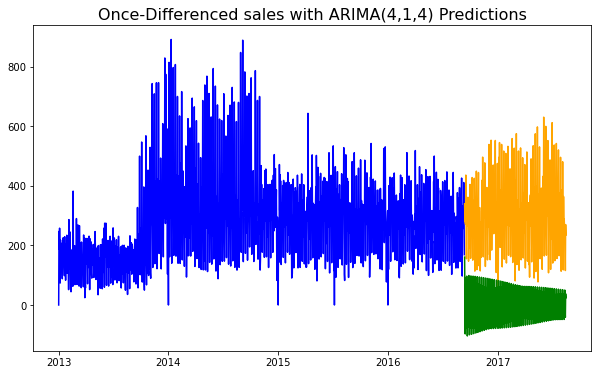

In [31]:
# Instantiate best model.
arima = ARIMA(endog=y_train, order=(4,1,4))


# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
preds = model.predict (start=1347, end =1683)

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced sales with ARIMA(4,1,4) Predictions', fontsize=16)
plt.show();

In [43]:
# Evaluate predictions.
mean_squared_error(y_test, preds)

107065.57595252621

We notice that the prediction isn't that great with ARIMA. So we will proceed to SARIMA

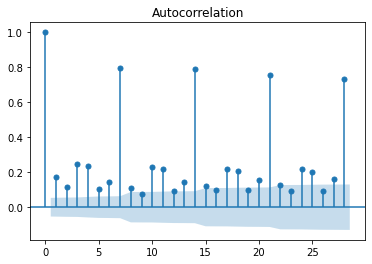

In [42]:
plot_acf(y_train, lags = 28);

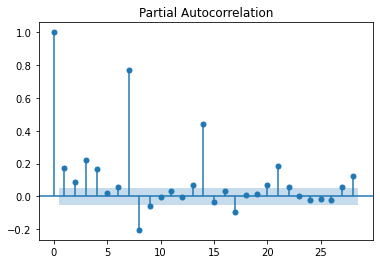

In [41]:
plot_pacf(y_train, lags = 28);

In [48]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = y_train,
                                 order = (4, 1, 4),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 7)) # (P, D, Q, S)

                # Fit SARIMA model.
                model = sarima.fit()

                # Generate predictions based on training set.
                # Start at time period 1347 and end at 1346.
                preds = model.predict(start=1347, end=1683)

                # Evaluate predictions.
                print(f'The MSE for (4, 1, 4)x({P},{D},{Q},7) is: {mean_squared_error(train["DOW"], preds)}')
                
                # Save for final report.
                if mse > mean_squared_error(y_train, preds):
                    mse = mean_squared_error(y_train, preds)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(4, 1, 4)x({final_P},{final_D},{final_Q},7).')
print(f'This model has an MSE of {mse}.')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27279D+00    |proj g|=  5.23884D-01

At iterate    5    f=  6.11136D+00    |proj g|=  1.37794D-01

At iterate   10    f=  6.09868D+00    |proj g|=  3.86447D-02

At iterate   15    f=  6.08872D+00    |proj g|=  3.23557D-02

At iterate   20    f=  6.08670D+00    |proj g|=  7.66689D-02

At iterate   25    f=  6.08399D+00    |proj g|=  5.06929D-02

At iterate   30    f=  6.07615D+00    |proj g|=  3.74922D-02

At iterate   35    f=  6.07584D+00    |proj g|=  1.24261D-02

At iterate   40    f=  6.07522D+00    |proj g|=  4.48102D-02

At iterate   45    f=  6.07514D+00    |proj g|=  9.45095D-03

At iterate   50    f=  6.07492D+00    |proj g|=  2.30219D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.82919D+00    |proj g|=  1.75132D-01

At iterate   10    f=  5.78685D+00    |proj g|=  1.61281D-01

At iterate   15    f=  5.78459D+00    |proj g|=  1.95554D-02

At iterate   20    f=  5.78417D+00    |proj g|=  8.11275D-03

At iterate   25    f=  5.78282D+00    |proj g|=  1.22381D-02

At iterate   30    f=  5.78141D+00    |proj g|=  4.33309D-03

At iterate   35    f=  5.78102D+00    |proj g|=  5.02295D-03

At iterate   40    f=  5.78063D+00    |proj g|=  1.83920D-02

At iterate   45    f=  5.77941D+00    |proj g|=  1.27354D-02

At iterate   50    f=  5.77685D+00    |proj g|=  8.73528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.24797D+00    |proj g|=  5.33268D-02

At iterate   15    f=  6.22701D+00    |proj g|=  3.56796D-02

At iterate   20    f=  6.22537D+00    |proj g|=  6.39527D-03

At iterate   25    f=  6.22521D+00    |proj g|=  1.41393D-02

At iterate   30    f=  6.22299D+00    |proj g|=  3.85561D-02

At iterate   35    f=  6.21914D+00    |proj g|=  3.11679D-01

At iterate   40    f=  6.20673D+00    |proj g|=  1.87658D-01

At iterate   45    f=  6.19429D+00    |proj g|=  1.32177D-01

At iterate   50    f=  6.19194D+00    |proj g|=  7.99881D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59   

 This problem is unconstrained.



At iterate   10    f=  6.02148D+00    |proj g|=  1.85799D-02

At iterate   15    f=  6.01500D+00    |proj g|=  3.85076D-02

At iterate   20    f=  6.01303D+00    |proj g|=  1.92764D-02

At iterate   25    f=  6.00828D+00    |proj g|=  1.57875D-01

At iterate   30    f=  6.00593D+00    |proj g|=  3.82060D-02

At iterate   35    f=  6.00539D+00    |proj g|=  1.94092D-01

At iterate   40    f=  6.00432D+00    |proj g|=  1.92902D-01

At iterate   45    f=  6.00257D+00    |proj g|=  1.96478D-01

At iterate   50    f=  6.00172D+00    |proj g|=  2.91716D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     65   

 This problem is unconstrained.



At iterate    5    f=  5.68931D+00    |proj g|=  2.24166D-02

At iterate   10    f=  5.68706D+00    |proj g|=  6.11603D-03

At iterate   15    f=  5.68305D+00    |proj g|=  1.05613D-02

At iterate   20    f=  5.67400D+00    |proj g|=  2.76023D-01

At iterate   25    f=  5.66134D+00    |proj g|=  2.71910D-01

At iterate   30    f=  5.64627D+00    |proj g|=  6.99860D-01

At iterate   35    f=  5.64487D+00    |proj g|=  3.98773D-01

At iterate   40    f=  5.64360D+00    |proj g|=  4.37710D-01

At iterate   45    f=  5.64204D+00    |proj g|=  4.91326D-01

At iterate   50    f=  5.64019D+00    |proj g|=  1.64344D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.08289D+00    |proj g|=  4.21208D-02

At iterate   10    f=  6.04726D+00    |proj g|=  1.14673D-02

At iterate   15    f=  6.04447D+00    |proj g|=  4.61775D-03

At iterate   20    f=  6.04207D+00    |proj g|=  1.79217D-02

At iterate   25    f=  6.01997D+00    |proj g|=  8.85539D-01

At iterate   30    f=  5.96189D+00    |proj g|=  3.56963D-01

At iterate   35    f=  5.88042D+00    |proj g|=  1.30999D+00

At iterate   40    f=  5.79700D+00    |proj g|=  3.72883D-01

At iterate   45    f=  5.79656D+00    |proj g|=  3.94009D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  5.79652D+00    |proj g|=  5.94554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50    108      2     0     0   5.946D-03   5.797D+00
  F =   5.7965224293993893     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02590D+00    |proj g|=  1.37098D-01


 This problem is unconstrained.



At iterate    5    f=  5.99188D+00    |proj g|=  3.81544D-02

At iterate   10    f=  5.97766D+00    |proj g|=  1.50742D-02

At iterate   15    f=  5.97272D+00    |proj g|=  1.73340D-02

At iterate   20    f=  5.97029D+00    |proj g|=  1.32211D-02

At iterate   25    f=  5.96506D+00    |proj g|=  1.89614D-01

At iterate   30    f=  5.96255D+00    |proj g|=  2.53342D-02

At iterate   35    f=  5.96039D+00    |proj g|=  7.73374D-02

At iterate   40    f=  5.95903D+00    |proj g|=  2.74257D-02

At iterate   45    f=  5.95860D+00    |proj g|=  3.05898D-02

At iterate   50    f=  5.95667D+00    |proj g|=  2.59057D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.69432D+00    |proj g|=  2.08941D-02

At iterate   10    f=  5.68565D+00    |proj g|=  4.29997D-03

At iterate   15    f=  5.68121D+00    |proj g|=  1.21646D-01

At iterate   20    f=  5.67534D+00    |proj g|=  4.08476D-01

At iterate   25    f=  5.66757D+00    |proj g|=  3.26625D-01

At iterate   30    f=  5.66039D+00    |proj g|=  3.84124D-02

At iterate   35    f=  5.65405D+00    |proj g|=  1.09208D-01

At iterate   40    f=  5.64277D+00    |proj g|=  1.38588D-01

At iterate   45    f=  5.63781D+00    |proj g|=  7.92906D-02

At iterate   50    f=  5.63779D+00    |proj g|=  7.53555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04420D+00    |proj g|=  3.66667D-02

At iterate    5    f=  6.02553D+00    |proj g|=  1.85925D-02

At iterate   10    f=  6.01218D+00    |proj g|=  8.23449D-03

At iterate   15    f=  5.88356D+00    |proj g|=  2.53077D-02

At iterate   20    f=  5.63523D+00    |proj g|=  1.85138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     23     44      1     0     0   3.037D-03   5.635D+00
  F =   5.6348358472389108     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96547D+00    |proj g|=  4.36200D-02

At iterate    5    f=  5.95365D+00    |proj g|=  4.06291D-02


 This problem is unconstrained.



At iterate   10    f=  5.94516D+00    |proj g|=  2.22845D-02

At iterate   15    f=  5.94117D+00    |proj g|=  2.92644D-02

At iterate   20    f=  5.92636D+00    |proj g|=  1.02927D-01

At iterate   25    f=  5.88887D+00    |proj g|=  5.35395D-01

At iterate   30    f=  5.83540D+00    |proj g|=  4.38380D-02

At iterate   35    f=  5.83508D+00    |proj g|=  5.30286D-02

At iterate   40    f=  5.83504D+00    |proj g|=  7.40606D-02

At iterate   45    f=  5.83302D+00    |proj g|=  9.94943D-01
  ys=-2.008E-03  -gs= 5.230E-03 BFGS update SKIPPED

At iterate   50    f=  5.80680D+00    |proj g|=  2.17972D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.74268D+00    |proj g|=  3.88847D-02

At iterate    5    f=  5.72045D+00    |proj g|=  3.98441D-02

At iterate   10    f=  5.70482D+00    |proj g|=  9.77039D-03

At iterate   15    f=  5.70064D+00    |proj g|=  3.88741D-02

At iterate   20    f=  5.69083D+00    |proj g|=  1.67995D-01

At iterate   25    f=  5.67980D+00    |proj g|=  2.42765D-01

At iterate   30    f=  5.67379D+00    |proj g|=  5.57220D-01

At iterate   35    f=  5.66654D+00    |proj g|=  1.44621D+00

At iterate   40    f=  5.66463D+00    |proj g|=  7.77084D-02

At iterate   45    f=  5.66445D+00    |proj g|=  6.73563D-02

At iterate   50    f=  5.66417D+00    |proj g|=  7.56649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.13494D+00    |proj g|=  1.09675D-01

At iterate   10    f=  6.10148D+00    |proj g|=  2.14170D-02

At iterate   15    f=  6.09458D+00    |proj g|=  1.48561D-02

At iterate   20    f=  6.09062D+00    |proj g|=  5.83285D-02

At iterate   25    f=  6.08876D+00    |proj g|=  9.00472D-02

At iterate   30    f=  6.08378D+00    |proj g|=  4.50679D-01

At iterate   35    f=  6.02829D+00    |proj g|=  1.30887D+00

At iterate   40    f=  5.97214D+00    |proj g|=  2.05331D-02

At iterate   45    f=  5.93734D+00    |proj g|=  2.26556D-01

At iterate   50    f=  5.92505D+00    |proj g|=  3.02578D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92629D+00    |proj g|=  4.54855D-02

At iterate    5    f=  5.91594D+00    |proj g|=  2.57847D-02

At iterate   10    f=  5.90638D+00    |proj g|=  8.07587D-03

At iterate   15    f=  5.90040D+00    |proj g|=  9.94772D-03

At iterate   20    f=  5.89133D+00    |proj g|=  5.40106D-02

At iterate   25    f=  5.88345D+00    |proj g|=  4.76449D-01

At iterate   30    f=  5.82281D+00    |proj g|=  8.37673D-01

At iterate   35    f=  5.72349D+00    |proj g|=  7.40919D-01

At iterate   40    f=  5.68769D+00    |proj g|=  1.21980D+00

At iterate   45    f=  5.67885D+00    |proj g|=  5.87697D+00

At iterate   50    f=  5.67837D+00    |proj g|=  1.28785D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72347D+00    |proj g|=  5.37261D-02

At iterate    5    f=  5.68981D+00    |proj g|=  2.18924D-02

At iterate   10    f=  5.68586D+00    |proj g|=  1.47135D-02

At iterate   15    f=  5.68339D+00    |proj g|=  1.10972D-02

At iterate   20    f=  5.67861D+00    |proj g|=  1.83506D-02

At iterate   25    f=  5.67326D+00    |proj g|=  2.89381D-01

At iterate   30    f=  5.66726D+00    |proj g|=  2.49469D-01

At iterate   35    f=  5.65496D+00    |proj g|=  8.45122D-01

At iterate   40    f=  5.64929D+00    |proj g|=  9.30210D-01

At iterate   45    f=  5.64095D+00    |proj g|=  6.44561D-01

At iterate   50    f=  5.63760D+00    |proj g|=  8.76144D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05485D+00    |proj g|=  3.35908D-02

At iterate    5    f=  6.02790D+00    |proj g|=  2.25549D-02

At iterate   10    f=  6.01741D+00    |proj g|=  7.57110D-03

At iterate   15    f=  6.01171D+00    |proj g|=  1.63263D-02

At iterate   20    f=  5.92418D+00    |proj g|=  7.79309D-01

At iterate   25    f=  5.83937D+00    |proj g|=  1.53277D+00

At iterate   30    f=  5.80466D+00    |proj g|=  3.37899D-01

At iterate   35    f=  5.80433D+00    |proj g|=  3.71206D-02

At iterate   40    f=  5.80432D+00    |proj g|=  7.80744D-03

At iterate   45    f=  5.80419D+00    |proj g|=  9.65588D-02

At iterate   50    f=  5.80188D+00    |proj g|=  3.63115D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.91471D+00    |proj g|=  2.23124D-02

At iterate   10    f=  5.90372D+00    |proj g|=  2.93639D-02

At iterate   15    f=  5.89298D+00    |proj g|=  1.89147D-01

At iterate   20    f=  5.85935D+00    |proj g|=  2.27676D-01

At iterate   25    f=  5.84188D+00    |proj g|=  8.97694D-01

At iterate   30    f=  5.79905D+00    |proj g|=  3.75865D-01

At iterate   35    f=  5.78645D+00    |proj g|=  3.41017D-01

At iterate   40    f=  5.78269D+00    |proj g|=  5.71643D-01

At iterate   45    f=  5.74648D+00    |proj g|=  1.69351D+00

At iterate   50    f=  5.68560D+00    |proj g|=  1.15493D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.71886D+00    |proj g|=  5.65270D-02

At iterate    5    f=  5.68861D+00    |proj g|=  1.68748D-02

At iterate   10    f=  5.68469D+00    |proj g|=  4.94911D-03

At iterate   15    f=  5.68080D+00    |proj g|=  1.23844D-01

At iterate   20    f=  5.67313D+00    |proj g|=  6.21844D-01

At iterate   25    f=  5.66275D+00    |proj g|=  9.90769D-01

At iterate   30    f=  5.64477D+00    |proj g|=  8.45451D-01

At iterate   35    f=  5.63874D+00    |proj g|=  1.33610D-01

At iterate   40    f=  5.63717D+00    |proj g|=  5.25455D-02

At iterate   45    f=  5.63716D+00    |proj g|=  1.03243D-02

At iterate   50    f=  5.63716D+00    |proj g|=  2.96343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15318D+00    |proj g|=  1.90346D-01

At iterate    5    f=  6.04108D+00    |proj g|=  1.84478D-02

At iterate   10    f=  6.02495D+00    |proj g|=  2.21050D-02

At iterate   15    f=  6.01410D+00    |proj g|=  1.27475D-02

At iterate   20    f=  6.00436D+00    |proj g|=  1.36297D-01

At iterate   25    f=  5.99812D+00    |proj g|=  5.91918D-02
  ys=-3.181E+08  -gs= 6.815E-01 BFGS update SKIPPED
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92698D+00    |proj g|=  3.60401D-02


 This problem is unconstrained.



At iterate    5    f=  5.91986D+00    |proj g|=  2.18280D-02

At iterate   10    f=  5.91287D+00    |proj g|=  5.42060D-03

At iterate   15    f=  5.90015D+00    |proj g|=  1.27587D-02

At iterate   20    f=  5.85458D+00    |proj g|=  2.51157D+00

At iterate   25    f=  5.78165D+00    |proj g|=  9.86544D-01

At iterate   30    f=  5.77443D+00    |proj g|=  2.33238D-01

At iterate   35    f=  5.76993D+00    |proj g|=  9.39387D-01

At iterate   40    f=  5.75493D+00    |proj g|=  1.82745D-01

At iterate   45    f=  5.73000D+00    |proj g|=  1.78270D+00

At iterate   50    f=  5.71357D+00    |proj g|=  1.01367D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.70434D+00    |proj g|=  4.58823D-02

At iterate   10    f=  5.69253D+00    |proj g|=  1.25594D-02

At iterate   15    f=  5.69088D+00    |proj g|=  4.73310D-03

At iterate   20    f=  5.67159D+00    |proj g|=  6.88171D-01

At iterate   25    f=  5.65774D+00    |proj g|=  1.59189D-01

At iterate   30    f=  5.65214D+00    |proj g|=  3.34273D-01

At iterate   35    f=  5.65005D+00    |proj g|=  1.90611D-01

At iterate   40    f=  5.64765D+00    |proj g|=  2.93112D-02

At iterate   45    f=  5.64744D+00    |proj g|=  1.50181D-02

At iterate   50    f=  5.64741D+00    |proj g|=  1.05802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.08163D+00    |proj g|=  2.38847D-02

At iterate   10    f=  6.06877D+00    |proj g|=  1.24699D-02

At iterate   15    f=  6.06339D+00    |proj g|=  6.27792D-03

At iterate   20    f=  6.06021D+00    |proj g|=  2.07939D-02

At iterate   25    f=  6.05274D+00    |proj g|=  1.92450D-02

At iterate   30    f=  6.04152D+00    |proj g|=  1.27917D-01

At iterate   35    f=  6.01080D+00    |proj g|=  1.79441D-01

At iterate   40    f=  5.92728D+00    |proj g|=  1.41931D+00

At iterate   45    f=  5.88062D+00    |proj g|=  1.31626D-01

At iterate   50    f=  5.87315D+00    |proj g|=  1.97393D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.91327D+00    |proj g|=  2.00248D-02

At iterate   10    f=  5.90462D+00    |proj g|=  7.83204D-03

At iterate   15    f=  5.90011D+00    |proj g|=  1.97891D-02

At iterate   20    f=  5.86701D+00    |proj g|=  1.56719D-01

At iterate   25    f=  5.82840D+00    |proj g|=  5.72297D-01

At iterate   30    f=  5.76989D+00    |proj g|=  5.16311D-01

At iterate   35    f=  5.76572D+00    |proj g|=  2.30076D-01

At iterate   40    f=  5.76550D+00    |proj g|=  8.67066D-02

At iterate   45    f=  5.76529D+00    |proj g|=  2.54710D-01

At iterate   50    f=  5.75876D+00    |proj g|=  1.70186D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72258D+00    |proj g|=  5.64815D-02

At iterate    5    f=  5.69594D+00    |proj g|=  5.22326D-02

At iterate   10    f=  5.68541D+00    |proj g|=  9.48887D-03

At iterate   15    f=  5.68292D+00    |proj g|=  2.10306D-02

At iterate   20    f=  5.67454D+00    |proj g|=  1.41945D-02

At iterate   25    f=  5.67177D+00    |proj g|=  3.45306D-02

At iterate   30    f=  5.66834D+00    |proj g|=  2.28802D-02

At iterate   35    f=  5.66443D+00    |proj g|=  1.23185D-01

At iterate   40    f=  5.65660D+00    |proj g|=  1.77048D-01

At iterate   45    f=  5.65222D+00    |proj g|=  7.59052D-02

At iterate   50    f=  5.65136D+00    |proj g|=  4.00935D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.06359D+00    |proj g|=  5.53951D-02

At iterate    5    f=  6.02514D+00    |proj g|=  3.91134D-02

At iterate   10    f=  6.01464D+00    |proj g|=  5.09317D-03

At iterate   15    f=  5.98941D+00    |proj g|=  1.14614D-01

At iterate   20    f=  5.72668D+00    |proj g|=  1.66121D-01

At iterate   25    f=  5.64180D+00    |proj g|=  5.94937D-03

At iterate   30    f=  5.64148D+00    |proj g|=  1.87947D-03

At iterate   35    f=  5.64145D+00    |proj g|=  9.30933D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  5.91198D+00    |proj g|=  1.86214D-02

At iterate   10    f=  5.90509D+00    |proj g|=  1.62624D-02

At iterate   15    f=  5.89940D+00    |proj g|=  1.52166D-02

At iterate   20    f=  5.84544D+00    |proj g|=  3.04590D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     22     76      2     0     0   4.843D+03  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.72015D+00    |proj g|=  5.75850D-02


 This problem is unconstrained.



At iterate    5    f=  5.69109D+00    |proj g|=  3.65806D-02

At iterate   10    f=  5.68483D+00    |proj g|=  2.05919D-02

At iterate   15    f=  5.68352D+00    |proj g|=  1.52147D-02

At iterate   20    f=  5.68022D+00    |proj g|=  7.57212D-03

At iterate   25    f=  5.67209D+00    |proj g|=  9.81200D-02

At iterate   30    f=  5.65444D+00    |proj g|=  2.09254D-01

At iterate   35    f=  5.64811D+00    |proj g|=  1.14712D-01

At iterate   40    f=  5.63854D+00    |proj g|=  8.25443D-02

At iterate   45    f=  5.63712D+00    |proj g|=  9.65528D-03

At iterate   50    f=  5.63671D+00    |proj g|=  1.79216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.02448D+00    |proj g|=  2.01639D-02

At iterate   10    f=  6.01594D+00    |proj g|=  5.89915D-03

At iterate   15    f=  6.01070D+00    |proj g|=  2.77351D-02

At iterate   20    f=  5.97287D+00    |proj g|=  3.70616D-02

At iterate   25    f=  5.85585D+00    |proj g|=  1.97823D+00
Our model that minimizes MSE on the training data is the SARIMA(4, 1, 4)x(0,0,0,7).
This model has an MSE of 990000000000000000.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27279D+00    |proj g|=  5.23884D-01

At iterate    5    f=  6.11136D+00    |proj g|=  1.37794D-01


 This problem is unconstrained.



At iterate   10    f=  6.09868D+00    |proj g|=  3.86447D-02

At iterate   15    f=  6.08872D+00    |proj g|=  3.23557D-02

At iterate   20    f=  6.08670D+00    |proj g|=  7.66689D-02

At iterate   25    f=  6.08399D+00    |proj g|=  5.06929D-02

At iterate   30    f=  6.07615D+00    |proj g|=  3.74922D-02

At iterate   35    f=  6.07584D+00    |proj g|=  1.24261D-02

At iterate   40    f=  6.07522D+00    |proj g|=  4.48102D-02

At iterate   45    f=  6.07514D+00    |proj g|=  9.45095D-03

At iterate   50    f=  6.07492D+00    |proj g|=  2.30219D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

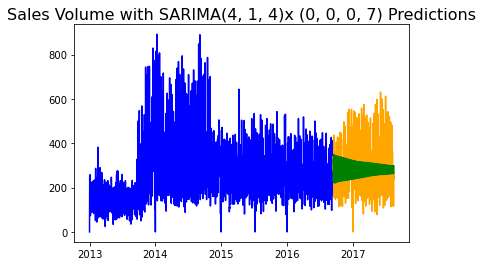

In [50]:
# Fit and visualize a SARIMA(4, 1, 4) x (0, 0, 0, 7) model.

sarima = SARIMAX(endog = y_train,
                 order = (4, 1, 4),              # (p, d, q)
                 seasonal_order = (0, 0, 0, 7)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 1347 and end at 1683.
preds = model.predict(start=1347, end=1683)

# Evaluate predictions.
print(mean_squared_error(y_test, preds))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Sales Volume with SARIMA(4, 1, 4)x (0, 0, 0, 7) Predictions', fontsize=16)
plt.show();